In [ ]:
#Import neccesary libraries

import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Load the data
from google.colab import files # Use to load data on Google Colab
uploaded = files.upload() # Use to load data on Google Colab

Saving ETH-USD.csv to ETH-USD.csv


In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('ETH-USD.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329.0
2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188.0
2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170.0
2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283.0
2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100.0


In [ ]:
eth = df
# Resampling to monthly frequency
eth_month = eth.resample('M').mean()

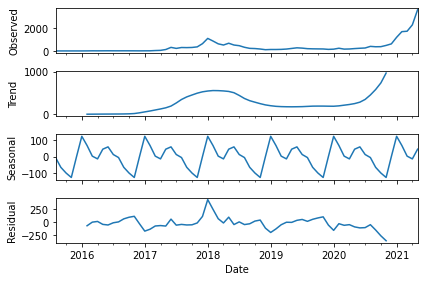

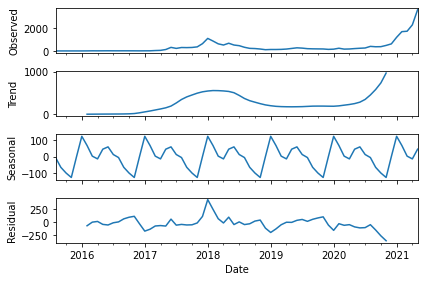

In [ ]:
seasonal_decompose(eth_month.Close).plot()

In [ ]:
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.Close)[1])
#p = a float datatype
#The p-value indicates that series is not stationary with 99.75% confidence.


Dickey–Fuller test: p=0.997597


In [ ]:
# Box-Cox Transformations
eth_month['close_box'], lmbda = stats.boxcox(eth_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.close_box)[1])

Dickey–Fuller test: p=0.916871


In [ ]:
# Seasonal differentiation (12 months)
eth_month['box_diff_seasonal_12'] = eth_month.close_box - eth_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.box_diff_seasonal_12[12:])[1])
#The p-value indicates that series is still not stationary.

Dickey–Fuller test: p=0.713413


In [ ]:
# Seasonal differentiation (3 months)
eth_month['box_diff_seasonal_3'] = eth_month.close_box - eth_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.box_diff_seasonal_3[3:])[1])
#3: is there because first 3 values won't come as there is no 3 values before the first one.

Dickey–Fuller test: p=0.198552


Dickey–Fuller test: p=0.000109


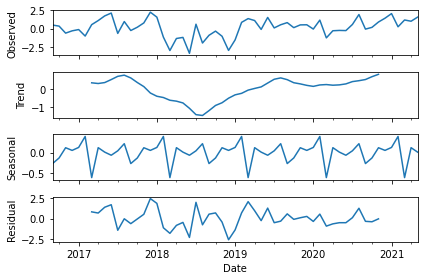

In [ ]:

# Regular differentiation
eth_month['box_diff2'] = eth_month.box_diff_seasonal_12 - eth_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(eth_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(eth_month.box_diff2[13:])[1])

plt.show()

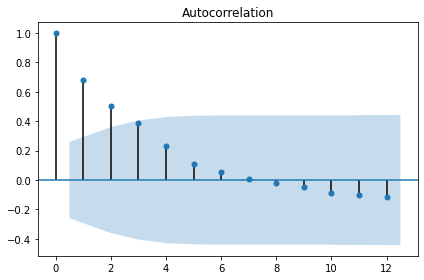

In [ ]:
#autocorrelation_plot(btc_month.close)
plot_acf(eth_month.Close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

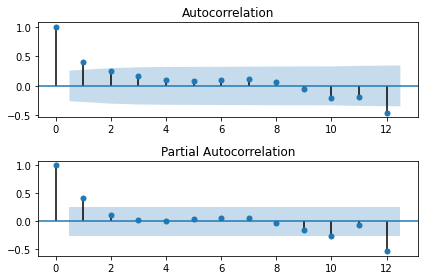

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function

plot_acf(eth_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(eth_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(eth_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0)  178.595435
4     (1, 1)  179.416652
1     (0, 1)  179.882301
5     (1, 2)  180.271064
6     (2, 0)  180.377781


In [ ]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:              close_box   No. Observations:                   70
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -87.298
Date:                Thu, 03 Jun 2021   AIC                            178.595
Time:                        22:44:33   BIC                            183.064
Sample:                    08-31-2015   HQIC                           180.368
                         - 05-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3975      0.083      4.790      0.000       0.235       0.560
sigma2         0.7334      0.126      5.834      0.000       0.487       0.980
Ljung-Box (Q):                       28.84   Jarque-

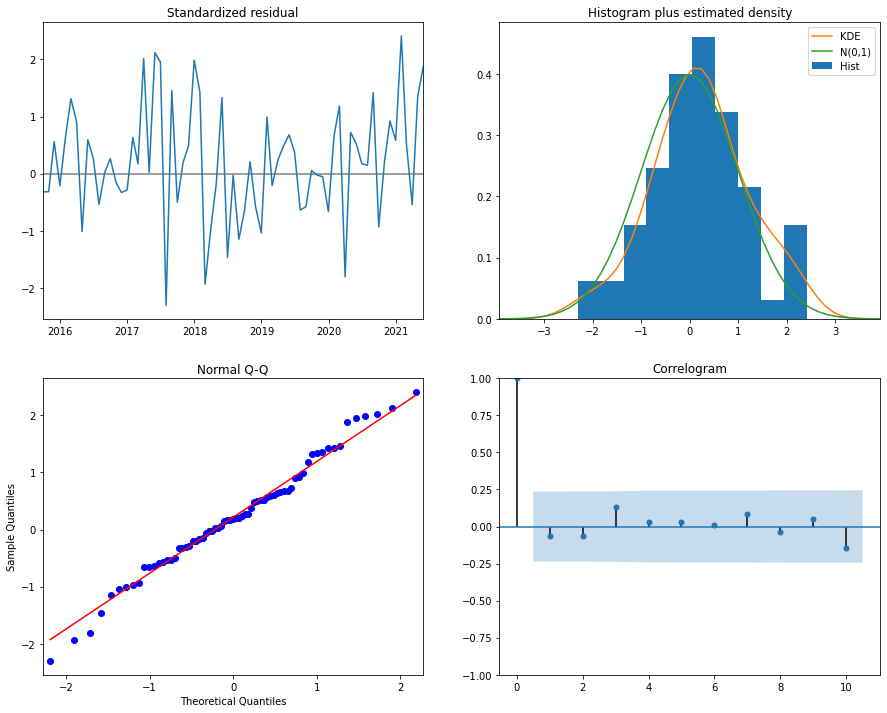

In [ ]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

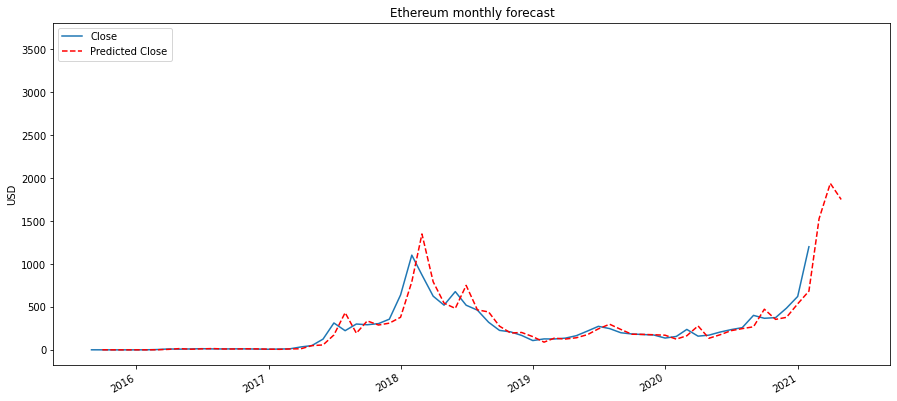

In [ ]:
# Prediction
eth_month_pred = eth_month[['Close']]

date_list = [datetime(2021, 1, 31), datetime(2021, 2, 28), datetime(2021, 3, 31), datetime(2021, 4, 30)]
future = pd.DataFrame(index=date_list, columns= eth_month.columns)
eth_month_pred = pd.concat([eth_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
eth_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2015, 9, 30), end=datetime(2021, 4, 30)), lmbda)
#We don't begin with start data as it is monthly spaced data we are considering.


plt.figure(figsize=(15,7))
eth_month_pred.Close.plot()
eth_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Ethereum monthly forecast')
plt.ylabel('USD')
plt.show()

In [ ]:
#ARIMA errors

# Compute the root mean square error
rmse = np.sqrt(((eth_month_pred.forecast - eth_month_pred.Close) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))




Mean Squared Error: 140.02


In [ ]:
from sklearn.metrics import mean_absolute_error

abc = eth_month_pred.Close - eth_month_pred.forecast
abc = abs(abc)
abc = abc[~np.isnan(abc)]
from statistics import mean
abc = mean(abc)
print(abc)
#print(mean_absolute_error) 

75.09275958712588


In [ ]:
from sklearn.metrics import r2_score

forecast = eth_month_pred['2020-01-01':'2021-01-01'].forecast
Close_1 = eth_month_pred['2020-01-01':'2021-01-01'].Close




from scipy.stats import pearsonr
corr, _ = pearsonr(Close_1, forecast)
r_squared = corr**2
print(r_squared)

0.7328274481727902


In [ ]:
##SARIMAX
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(eth_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  176.570768
25  (1, 1, 0, 1)  177.416121
7   (0, 1, 0, 1)  178.025003
37  (2, 0, 0, 1)  178.034728
21  (1, 0, 1, 1)  178.565348
                                 Statespace Model Results                                
Dep. Variable:                         close_box   No. Observations:                   70
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 4)   Log Likelihood                 -85.285
Date:                           Thu, 03 Jun 2021   AIC                            176.571
Time:                                   22:45:51   BIC                            183.094
Sample:                               08-31-2015   HQIC                           179.145
                                    - 05-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

In [ ]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


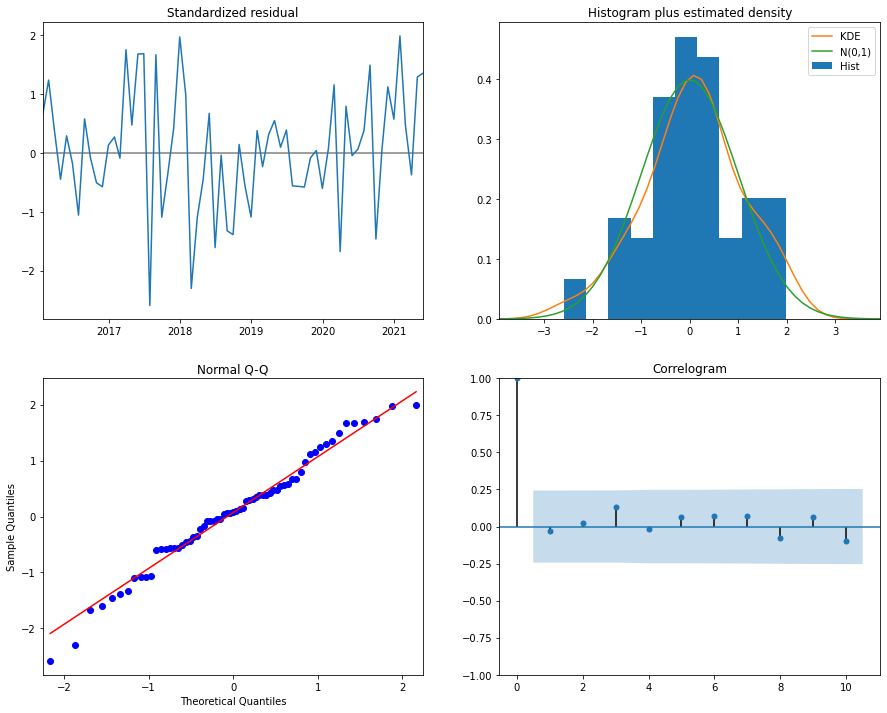

In [ ]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.000000


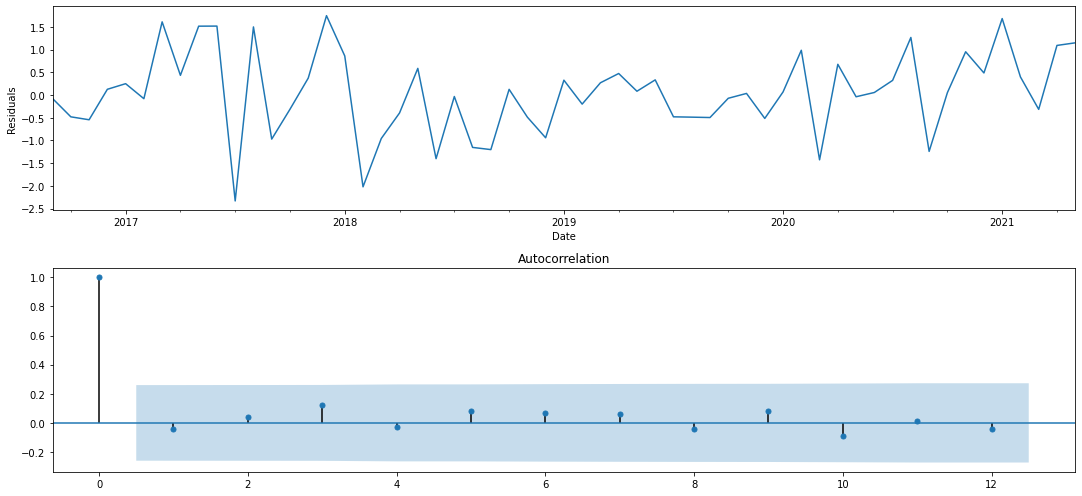

In [ ]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

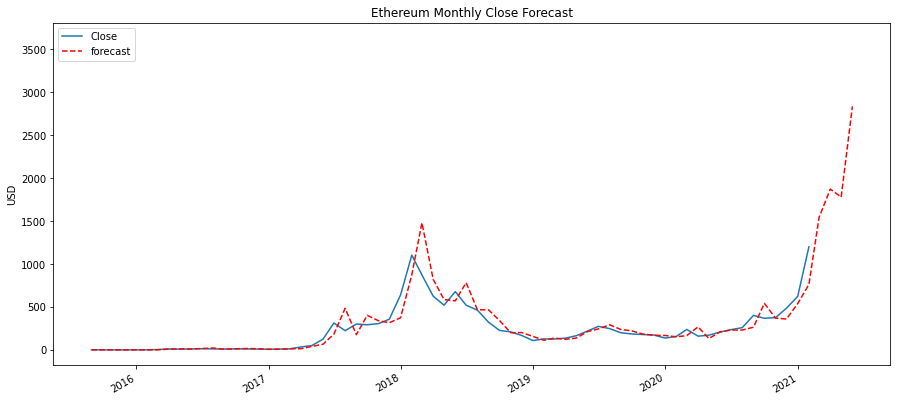

In [ ]:
# Prediction with SARIMAX
eth_month2 = eth_month[['Close']]
date_list = [datetime(2021, 1, 31), datetime(2021, 2, 28), datetime(2021, 3, 31), datetime(2021, 4, 30)]
future = pd.DataFrame(index=date_list, columns= eth_month.columns)
eth_month2 = pd.concat([eth_month2, future])

eth_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
eth_month2.Close.plot()
eth_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Ethereum Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('Ethereum_monthly_forecast.png')
plt.show()

In [ ]:
##VALIDATION

#A simple indicator of how accurate out forecast is is the root mean square error (RMSE). 
#So lets calcualte RMSE for the one-step ahead predictions starting from 2019, through to the end of Apr 2021.

y_forecasted = eth_month2.forecast
y_truth = eth_month2['2020-01-01':'2021-01-01'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

##y_truth = eth_month2['2015-01-01':'2017-01-01'].Close - Mean Squared Error: 3.33
##y_truth = eth_month2['2020-01-01':'2021-01-01'].Close - Mean Squared Error: 87.4

Mean Squared Error: 87.4


In [ ]:

from sklearn.metrics import mean_absolute_error

abc = eth_month2.Close - eth_month2.forecast
abc = abs(abc)
abc = abc[~np.isnan(abc)]
from statistics import mean
abc = mean(abc)
print(abc)
#print(mean_absolute_error) 

85.82106880734867


In [ ]:
from sklearn.metrics import r2_score

forecast = eth_month2['2020-01-01':'2021-01-01'].forecast



from scipy.stats import pearsonr
corr, _ = pearsonr(y_truth, forecast)

r_squared = corr**2
print(r_squared)

0.6448775319021616
